In [1]:
import os
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from math import pi
import plancklens
from plancklens import utils, n0s
from plancklens import nhl
from plancklens.n1 import n1
from plancklens import qest, qecl, qresp
import matplotlib as mpl

from orphics import maps, cosmology
mpl.rcParams['font.size']=12

In [2]:
exps_config = {
    'CMB_S3': {
        'nlev_t': 7,
        'nlev_p':7*2**0.5,
        'beam_arcmin': 1.4,
        'result_nums': [0, 20, 40, 60, 80]
    },
    'CMB_S4': {
        'nlev_t': 1,
        'nlev_p':2**0.5,
        'beam_arcmin': 1.4,
        'result_nums': [90, 110, 130, 150, 170]
    }
}

In [41]:
A_cb = 1e-08
experiment = 'CMB_S4'

lmax = 3000
ellmin = 30
ellmax = 3000
Lmax = 3000

ls = np.arange(lmax+1)
ells = np.arange(ellmax+1)

In [42]:
theory = cosmology.default_theory()
cltt, clee, clbb = theory.lCl('TT', ls), theory.lCl('EE', ls), theory.lCl('BB', ls)
clte = theory.lCl('TE', ls)

In [43]:
main_path = '/home/hongbo/projects/lens_rot_bias/'
cls_path = '/home/hongbo/projects/lens_rot_bias/inputPs'
claa = np.loadtxt(cls_path + '/claa_A%s.txt' %A_cb)[:,1]

In [44]:
clpp = np.loadtxt(cls_path + '/cosmo2017_10K_acc3_lenspotentialCls.dat', \
                  usecols=(5), unpack=True)
fac = (ls*(ls+1))**2/(2*pi)
fac[0] = 1
clpp = np.concatenate(([1,1], clpp))[ls]/fac
clpp[0], clpp[1] = 0, 0

In [45]:
nltt = (exps_config[experiment]['nlev_t']*\
        pi/180/60)**2/maps.gauss_beam(ls, exps_config[experiment]['beam_arcmin'])**2
nlee = (exps_config[experiment]['nlev_p']*\
        pi/180/60)**2/maps.gauss_beam(ls, exps_config[experiment]['beam_arcmin'])**2
nlbb = nlee

ocltt = cltt + nltt
oclee = clee + nlee
oclbb = clbb + nlbb
oclee[0], oclee[1], oclbb[0], oclbb[1] = 1, 1, 1, 1

In [46]:
ftl = 1/ocltt[:lmax+1]
fel = 1/oclee[:lmax+1]
fbl = 1/oclbb[:lmax+1]

# ftl[:ellmin] *= 0.
# fel[:ellmin] *= 0.
# fbl[:ellmin] *= 0.

ftl[:2] *= 0.
fel[:2] *= 0.
fbl[:2] *= 0.

In [47]:
n1aa_integral = []

for result_num in exps_config[experiment]['result_nums']:
    n1aa_integral.append(np.loadtxt(main_path+'/output/N1aa/N1aa_%s_%s_%s_30_3000.dat' \
                                    %(result_num, A_cb, experiment)))

n1aa_integral = np.array(n1aa_integral)
n1aa_sim = np.mean(n1aa_integral, axis=0)

In [48]:
#---- N1 lensing bias library:
n1_dd = n1.library_n1(main_path+'/test_N1aa/',cltt,clte,clee)
N0s, N0_curls = n0s.get_N0(beam_fwhm=exps_config[experiment]['beam_arcmin'],\
                           nlev_t=exps_config[experiment]['nlev_t'], \
                           nlev_p=exps_config[experiment]['nlev_p'], joint_TP=False, ksource='p')

In [49]:
n1aa = n1_dd.get_n1('peb', 'r', claa[:4001], ftl, fel, fbl, 3000)

n1: doing L 1 kA peb kB peb kind r
n1: doing L 2 kA peb kB peb kind r
n1: doing L 3 kA peb kB peb kind r
n1: doing L 4 kA peb kB peb kind r
n1: doing L 5 kA peb kB peb kind r
n1: doing L 6 kA peb kB peb kind r
n1: doing L 7 kA peb kB peb kind r
n1: doing L 8 kA peb kB peb kind r
n1: doing L 9 kA peb kB peb kind r
n1: doing L 10 kA peb kB peb kind r
n1: doing L 21 kA peb kB peb kind r
n1: doing L 41 kA peb kB peb kind r
n1: doing L 61 kA peb kB peb kind r
n1: doing L 81 kA peb kB peb kind r
n1: doing L 101 kA peb kB peb kind r
n1: doing L 121 kA peb kB peb kind r
n1: doing L 141 kA peb kB peb kind r
n1: doing L 161 kA peb kB peb kind r
n1: doing L 181 kA peb kB peb kind r
n1: doing L 201 kA peb kB peb kind r
n1: doing L 221 kA peb kB peb kind r
n1: doing L 241 kA peb kB peb kind r
n1: doing L 261 kA peb kB peb kind r
n1: doing L 281 kA peb kB peb kind r
n1: doing L 301 kA peb kB peb kind r
n1: doing L 321 kA peb kB peb kind r
n1: doing L 341 kA peb kB peb kind r
n1: doing L 361 kA peb k

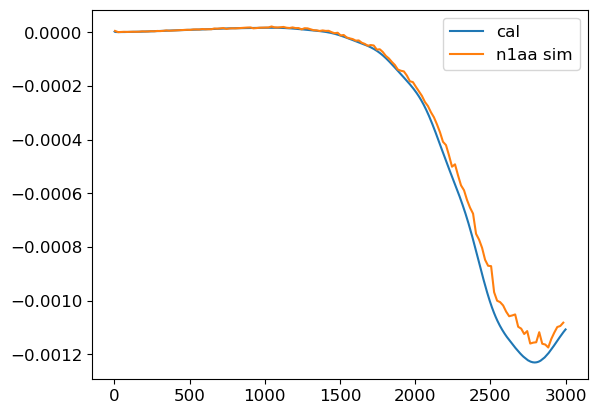

In [52]:
Ls = np.arange(5, ellmax+1, 20)
frac_bias=((N0s['p_p'])**2*n1aa)[2:]/clpp[2:]
plt.plot(ls[2:], pi*frac_bias, label='cal')
plt.plot(Ls, n1aa_sim[Ls]/clpp[Ls], label='n1aa sim')
plt.legend()

In [18]:
# n1pp = n1_dd.get_n1('peb', 'p', clpp, ftl, fel, fbl, ellmax)

n1: doing L 3 kA peb kB peb kind p


n1: doing L 4 kA peb kB peb kind p


n1: doing L 5 kA peb kB peb kind p


n1: doing L 6 kA peb kB peb kind p


n1: doing L 7 kA peb kB peb kind p


n1: doing L 8 kA peb kB peb kind p


n1: doing L 9 kA peb kB peb kind p


n1: doing L 10 kA peb kB peb kind p


n1: doing L 21 kA peb kB peb kind p


n1: doing L 41 kA peb kB peb kind p


n1: doing L 61 kA peb kB peb kind p


n1: doing L 81 kA peb kB peb kind p


n1: doing L 101 kA peb kB peb kind p


n1: doing L 121 kA peb kB peb kind p


n1: doing L 141 kA peb kB peb kind p


n1: doing L 161 kA peb kB peb kind p


n1: doing L 181 kA peb kB peb kind p


n1: doing L 201 kA peb kB peb kind p


n1: doing L 221 kA peb kB peb kind p


n1: doing L 241 kA peb kB peb kind p


n1: doing L 261 kA peb kB peb kind p


n1: doing L 281 kA peb kB peb kind p


n1: doing L 301 kA peb kB peb kind p


n1: doing L 321 kA peb kB peb kind p


n1: doing L 341 kA peb kB peb kind p


n1: doing L 361 kA peb kB peb kind p


n1: doing L 381 kA peb kB peb kind p


n1: doing L 401 kA peb kB peb kind p


n1: doing L 421 kA peb kB peb kind p


n1: doing L 441 kA peb kB peb kind p


n1: doing L 461 kA peb kB peb kind p


n1: doing L 481 kA peb kB peb kind p


n1: doing L 501 kA peb kB peb kind p


n1: doing L 521 kA peb kB peb kind p


n1: doing L 541 kA peb kB peb kind p


n1: doing L 561 kA peb kB peb kind p


n1: doing L 581 kA peb kB peb kind p


n1: doing L 601 kA peb kB peb kind p


n1: doing L 621 kA peb kB peb kind p


n1: doing L 641 kA peb kB peb kind p


n1: doing L 661 kA peb kB peb kind p


n1: doing L 681 kA peb kB peb kind p


n1: doing L 701 kA peb kB peb kind p


n1: doing L 721 kA peb kB peb kind p


n1: doing L 741 kA peb kB peb kind p


n1: doing L 761 kA peb kB peb kind p


n1: doing L 781 kA peb kB peb kind p


n1: doing L 801 kA peb kB peb kind p


n1: doing L 821 kA peb kB peb kind p


n1: doing L 841 kA peb kB peb kind p


n1: doing L 861 kA peb kB peb kind p


n1: doing L 881 kA peb kB peb kind p


n1: doing L 901 kA peb kB peb kind p


n1: doing L 921 kA peb kB peb kind p


n1: doing L 941 kA peb kB peb kind p


n1: doing L 961 kA peb kB peb kind p


n1: doing L 981 kA peb kB peb kind p


n1: doing L 1001 kA peb kB peb kind p


n1: doing L 1021 kA peb kB peb kind p


n1: doing L 1041 kA peb kB peb kind p


n1: doing L 1061 kA peb kB peb kind p


n1: doing L 1081 kA peb kB peb kind p


n1: doing L 1101 kA peb kB peb kind p


n1: doing L 1121 kA peb kB peb kind p


n1: doing L 1141 kA peb kB peb kind p


n1: doing L 1161 kA peb kB peb kind p


n1: doing L 1181 kA peb kB peb kind p


n1: doing L 1201 kA peb kB peb kind p


n1: doing L 1221 kA peb kB peb kind p


n1: doing L 1241 kA peb kB peb kind p


n1: doing L 1261 kA peb kB peb kind p


n1: doing L 1281 kA peb kB peb kind p


n1: doing L 1301 kA peb kB peb kind p


n1: doing L 1321 kA peb kB peb kind p


n1: doing L 1341 kA peb kB peb kind p


n1: doing L 1361 kA peb kB peb kind p


n1: doing L 1381 kA peb kB peb kind p


n1: doing L 1401 kA peb kB peb kind p


n1: doing L 1421 kA peb kB peb kind p


n1: doing L 1441 kA peb kB peb kind p


n1: doing L 1461 kA peb kB peb kind p


n1: doing L 1481 kA peb kB peb kind p


n1: doing L 1501 kA peb kB peb kind p


n1: doing L 1521 kA peb kB peb kind p


n1: doing L 1541 kA peb kB peb kind p


n1: doing L 1561 kA peb kB peb kind p


n1: doing L 1581 kA peb kB peb kind p


n1: doing L 1601 kA peb kB peb kind p


n1: doing L 1621 kA peb kB peb kind p


n1: doing L 1641 kA peb kB peb kind p


n1: doing L 1661 kA peb kB peb kind p


n1: doing L 1681 kA peb kB peb kind p


n1: doing L 1701 kA peb kB peb kind p


n1: doing L 1721 kA peb kB peb kind p


n1: doing L 1741 kA peb kB peb kind p


n1: doing L 1761 kA peb kB peb kind p


n1: doing L 1781 kA peb kB peb kind p


n1: doing L 1801 kA peb kB peb kind p


n1: doing L 1821 kA peb kB peb kind p


n1: doing L 1841 kA peb kB peb kind p


n1: doing L 1861 kA peb kB peb kind p


n1: doing L 1881 kA peb kB peb kind p


n1: doing L 1901 kA peb kB peb kind p


n1: doing L 1921 kA peb kB peb kind p


n1: doing L 1941 kA peb kB peb kind p


n1: doing L 1961 kA peb kB peb kind p


n1: doing L 1981 kA peb kB peb kind p


n1: doing L 2001 kA peb kB peb kind p


n1: doing L 2021 kA peb kB peb kind p


n1: doing L 2041 kA peb kB peb kind p


n1: doing L 2061 kA peb kB peb kind p


n1: doing L 2081 kA peb kB peb kind p


n1: doing L 2101 kA peb kB peb kind p


n1: doing L 2121 kA peb kB peb kind p


n1: doing L 2141 kA peb kB peb kind p


n1: doing L 2161 kA peb kB peb kind p


n1: doing L 2181 kA peb kB peb kind p


n1: doing L 2201 kA peb kB peb kind p


n1: doing L 2221 kA peb kB peb kind p


n1: doing L 2241 kA peb kB peb kind p


n1: doing L 2261 kA peb kB peb kind p


n1: doing L 2281 kA peb kB peb kind p


n1: doing L 2301 kA peb kB peb kind p


n1: doing L 2321 kA peb kB peb kind p


n1: doing L 2341 kA peb kB peb kind p


n1: doing L 2361 kA peb kB peb kind p


n1: doing L 2381 kA peb kB peb kind p


n1: doing L 2401 kA peb kB peb kind p


n1: doing L 2421 kA peb kB peb kind p


n1: doing L 2441 kA peb kB peb kind p


n1: doing L 2461 kA peb kB peb kind p


n1: doing L 2481 kA peb kB peb kind p


n1: doing L 2501 kA peb kB peb kind p


n1: doing L 2521 kA peb kB peb kind p


n1: doing L 2541 kA peb kB peb kind p


n1: doing L 2561 kA peb kB peb kind p


n1: doing L 2581 kA peb kB peb kind p


n1: doing L 2601 kA peb kB peb kind p


n1: doing L 2621 kA peb kB peb kind p


n1: doing L 2641 kA peb kB peb kind p


n1: doing L 2661 kA peb kB peb kind p


n1: doing L 2681 kA peb kB peb kind p


n1: doing L 2701 kA peb kB peb kind p


n1: doing L 2721 kA peb kB peb kind p


n1: doing L 2741 kA peb kB peb kind p


n1: doing L 2761 kA peb kB peb kind p


n1: doing L 2781 kA peb kB peb kind p


n1: doing L 2801 kA peb kB peb kind p


n1: doing L 2821 kA peb kB peb kind p


n1: doing L 2841 kA peb kB peb kind p


n1: doing L 2861 kA peb kB peb kind p


n1: doing L 2881 kA peb kB peb kind p


n1: doing L 2901 kA peb kB peb kind p


n1: doing L 2921 kA peb kB peb kind p


n1: doing L 2941 kA peb kB peb kind p


n1: doing L 2961 kA peb kB peb kind p


n1: doing L 2981 kA peb kB peb kind p


n1: doing L 3000 kA peb kB peb kind p
